# **Import Library**

In [ ]:
import pyspark
print(pyspark.__version__)

from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, date_format, collect_set
from pyspark.sql.functions import array, array_sort, udf, col
from pyspark.ml.feature import CountVectorizer, MinHashLSH
import time
import matplotlib.pyplot as plt
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import SparseVector
import numpy as np
from pyspark.sql.functions import expr

3.5.5


# **Data Processing**

**1. Connect to Gg Drive to get data**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/MMDS"

baskets.csv


**2. Read data by using DataFrame**

In [ ]:
#Initialize a SparkSession
spark = SparkSession.builder.appName('MinHashLSH').getOrCreate()

#Read data from Gg Drive
df = spark.read.csv("/content/drive/MyDrive/MMDS/baskets.csv", \
                    header=True, inferSchema=True)

#Show structure of df
print("Structure of DataFrame")
df.printSchema()

#Show first 5 rows in df
print("First 5 rows in DataFrame")
df.show(5)

#Convert "Date" from string to DateType
df_convert = df.withColumn("Date", to_date(df["Date"], "dd/MM/yyyy"))

#Show first 5 rows in df after covert
print("First 5 rows in DataFrame after convert")
df_convert.show(5)

#Group items by purchase date
print("Group items by purchase date")
grouped_df = df_convert.groupBy("Date") \
.agg(collect_set("itemDescription").alias("items"))

grouped_df.show(10)

Structure of DataFrame
root
 |-- Member_number: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)

First 5 rows in DataFrame
+-------------+----------+----------------+----+-----+---+-----------+
|Member_number|      Date| itemDescription|year|month|day|day_of_week|
+-------------+----------+----------------+----+-----+---+-----------+
|         1249|01/01/2014|    citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|          coffee|2014|    1|  1|          2|
|         1381|01/01/2014|            curd|2014|    1|  1|          2|
|         1381|01/01/2014|            soda|2014|    1|  1|          2|
|         1440|01/01/2014|other vegetables|2014|    1|  1|          2|
+-------------+----------+----------------+----+-----+---+-----------+
only showing top 5 row

In [ ]:
#Count distinct items
dist_items = df.select("itemDescription").distinct().count()
print("The number of distinguishing items is",dist_items)

The number of distinguishing items is 167


In [ ]:
#Creat CountVectorizer
cv = CountVectorizer(inputCol="items", outputCol="features", \
                     vocabSize=200, binary=True)

#Train CountVectorizer to find list of frequent items from dataset
cv_model = cv.fit(grouped_df)

#Covert data to Sparse Vector
cv_df = cv_model.transform(grouped_df)

#Show first 5 rows in cv_df
print("First 5 rows in cv_df")
cv_df.show(5)
cv_df.count()

First 5 rows in cv_df
+----------+--------------------+--------------------+
|      Date|               items|            features|
+----------+--------------------+--------------------+
|2014-01-01|[whole milk, yogu...|(167,[0,1,3,4,6,7...|
|2014-01-02|[whole milk, cond...|(167,[0,1,2,3,4,5...|
|2014-01-03|[whole milk, suga...|(167,[0,1,3,4,5,7...|
|2014-01-04|[flour, whole mil...|(167,[0,2,3,4,5,6...|
|2014-01-05|[flour, whole mil...|(167,[0,1,2,3,5,6...|
+----------+--------------------+--------------------+
only showing top 5 rows



728

# **Approach 1: MinHashLSH**

## **1. MinHashLSH**

In [ ]:
def approach1(cv_df, threshold, num_hash):
  #Initialize MinHashLSH
  mh = MinHashLSH(inputCol="features", \
                  outputCol="hashValues", \
                  seed = 12345, \
                  numHashTables=num_hash)

  #Fit data to MinHashLSH
  lsh_model = mh.fit(cv_df)

  #Add hashes column
  transformed_df = lsh_model.transform(cv_df)

  #Find two dates with Jaccard Similarity >= 0.5
  similar_dates = lsh_model \
  .approxSimilarityJoin(transformed_df, transformed_df, 1 - threshold + 0.000001, \
                        distCol="Jaccard Distance") \
                        .filter("datasetA.date < datasetB.date")

  exact_pairs = similar_dates.withColumn(
      "JaccardSimilarity", 1 - col("Jaccard Distance")
  )
  return exact_pairs

In [ ]:
num_hash_tables_list = [5,10,20,30]
results = []

for num_hash in num_hash_tables_list:
  start_time = time.time()

  similar_dates = approach1(cv_df, 0.5, num_hash)

  #Show result
  print("Number of hash tables:", num_hash)
  print("Two dates with Jaccard Distance <= 0.5")
  print("The number of similarity dates",similar_dates.count())

  elapsed = time.time() - start_time
  print(f"Running time: {elapsed:.2f} seconds")

  similar_dates.select("datasetA.date", "datasetB.date", "JaccardSimilarity").show(5)

  results.append((num_hash, similar_dates.count(), elapsed))

Number of hash tables: 5
Two dates with Jaccard Distance <= 0.5
The number of similarity dates 203
Running time: 5.97 seconds
+----------+----------+------------------+
|      date|      date| JaccardSimilarity|
+----------+----------+------------------+
|2014-08-28|2014-11-13|0.5087719298245614|
|2015-01-21|2015-08-12|               0.5|
|2015-03-18|2015-11-10|0.5178571428571429|
|2014-07-11|2015-09-09|               0.5|
|2015-01-22|2015-11-26|0.5106382978723404|
+----------+----------+------------------+
only showing top 5 rows

Number of hash tables: 10
Two dates with Jaccard Distance <= 0.5
The number of similarity dates 222
Running time: 8.79 seconds
+----------+----------+------------------+
|      date|      date| JaccardSimilarity|
+----------+----------+------------------+
|2015-01-22|2015-07-13|               0.5|
|2015-02-18|2015-04-07|               0.5|
|2015-07-13|2015-12-16|               0.5|
|2015-07-21|2015-11-27|               0.5|
|2014-06-01|2015-02-07|0.509803921

In [ ]:
from pyspark.sql.functions import col

df_filtered = similar_dates.filter(col("JaccardSimilarity") < 0.5)
df_filtered.show()

+--------+--------+----------------+-----------------+
|datasetA|datasetB|Jaccard Distance|JaccardSimilarity|
+--------+--------+----------------+-----------------+
+--------+--------+----------------+-----------------+



## **2. Plot**

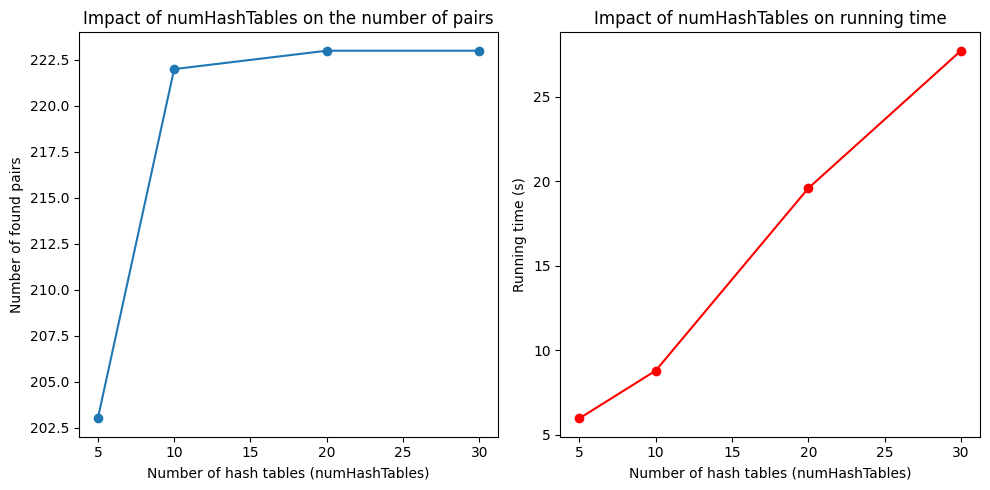

In [ ]:
num_hash_values, counts, times = zip(*results)

#Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(num_hash_values, counts, marker='o', linestyle='-')
plt.xlabel("Number of hash tables (numHashTables)")
plt.ylabel("Number of found pairs")
plt.title("Impact of numHashTables on the number of pairs")

#Plot
plt.subplot(1, 2, 2)
plt.plot(num_hash_values, times, marker='o', linestyle='-', color='r')
plt.xlabel("Number of hash tables (numHashTables)")
plt.ylabel("Running time (s)")
plt.title("Impact of numHashTables on running time")

plt.tight_layout()
plt.show()

# **Approach 2: Brute-force**

In [ ]:
def jaccard_similarity_sparse(vec1, vec2):
    if isinstance(vec1, SparseVector) and isinstance(vec2, SparseVector):
        indices1 = set(vec1.indices)
        indices2 = set(vec2.indices)
        intersection = len(indices1 & indices2)
        union = len(indices1 | indices2)
        return float(intersection) / union if union != 0 else 0
    else:
        return 0.0

def approach2(cv_df, threhold):
  #Initialize UDF
  jaccard_udf = udf(jaccard_similarity_sparse, FloatType())

  #Generate all pairs
  join_df = cv_df.alias("A").join(cv_df.alias("B"), \
                                  col("A.Date") < col("B.Date"))

  #Compute Jaccard Similarity on SparseVector
  similar_dates_bf = join_df.withColumn("Jaccard Similarity", \
                                        jaccard_udf(col("A.features"), \
                                                    col("B.features")))

  df_similar_filtered = similar_dates_bf.filter(col("Jaccard Similarity") >= threhold)

  return df_similar_filtered

In [ ]:
threshold = 0.5

start_time_2 = time.time()

df_similar_filtered = approach2(cv_df, threshold)

print("The number of similarity dates", df_similar_filtered.count())

elapsed_2 = time.time() - start_time_2
print(f"Running time: {elapsed_2:.2f} seconds")

print(f"Two dates with Jaccard Similarity >= {threshold}")

df_similar_filtered.select(
    col("A.Date").alias("date1"),
    col("B.Date").alias("date2"),
    col("Jaccard Similarity").alias("Jaccard Similarity")
).show(50)

The number of similarity dates 223
Running time: 31.88 seconds
Two dates with Jaccard Similarity >= 0.5
+----------+----------+------------------+
|     date1|     date2|Jaccard Similarity|
+----------+----------+------------------+
|2014-01-02|2014-06-12|         0.5090909|
|2014-01-02|2015-11-10|        0.55932206|
|2014-01-12|2014-02-02|         0.5121951|
|2014-01-13|2015-08-01|               0.5|
|2014-01-21|2014-06-09|         0.5185185|
|2014-01-22|2014-05-24|         0.5135135|
|2014-01-28|2014-09-05|               0.5|
|2014-01-30|2014-02-01|               0.5|
|2014-01-30|2014-08-26|         0.5272727|
|2014-02-02|2014-07-14|        0.55263156|
|2014-02-03|2014-09-05|         0.5208333|
|2014-02-03|2015-07-27|         0.5531915|
|2014-02-05|2014-08-11|               0.5|
|2014-02-05|2015-11-02|               0.5|
|2014-02-08|2014-10-14|               0.5|
|2014-02-08|2015-03-30|              0.54|
|2014-02-19|2014-09-05|        0.51111114|
|2014-02-26|2015-08-28|             

# **Draw chart to contrast the running time of the two approaches for s in range [0.0, 1.0], step = 0.1.**

In [ ]:
minhash_times = []
brute_force_times = []
s_values = np.arange(0.0, 1.1, 0.1)

#Approach 1: MinHashLSH
print("Approach 1: MinHashLSH")
print("-"*30)
for threshold in s_values:
  start_time_minhash = time.time()

  similar_dates_MinHashLSH = approach1(cv_df, threshold, 10)
  print(f"s = {threshold:.1f}   --> There are {similar_dates_MinHashLSH.count()} pairs")

  elapsed_minhash = time.time() - start_time_minhash
  print(f"Running time: {elapsed_minhash:.2f} seconds\n")

  minhash_times.append(elapsed_minhash)

#Approach 2: Brute-force
print("\n\nApproach 2: Brute-force")
print("-"*30)
for threshold in s_values:
  start_time_brute_force = time.time()

  similar_dates_Brute_Force = approach2(cv_df, threshold)
  print(f"s = {threshold:.1f}   --> There are {similar_dates_Brute_Force.count()} pairs")

  elapsed_brute_force = time.time() - start_time_brute_force
  print(f"Running time: {elapsed_brute_force:.2f} seconds\n")

  brute_force_times.append(elapsed_brute_force)

Approach 1: MinHashLSH
------------------------------
s = 0.0   --> There are 235630 pairs
Running time: 29.34 seconds

s = 0.1   --> There are 235592 pairs
Running time: 24.50 seconds

s = 0.2   --> There are 221838 pairs
Running time: 24.33 seconds

s = 0.3   --> There are 100792 pairs
Running time: 12.34 seconds

s = 0.4   --> There are 9992 pairs
Running time: 9.85 seconds

s = 0.5   --> There are 222 pairs
Running time: 8.34 seconds

s = 0.6   --> There are 3 pairs
Running time: 7.88 seconds

s = 0.7   --> There are 0 pairs
Running time: 9.07 seconds

s = 0.8   --> There are 0 pairs
Running time: 7.39 seconds

s = 0.9   --> There are 0 pairs
Running time: 8.96 seconds

s = 1.0   --> There are 0 pairs
Running time: 8.80 seconds



Approach 2: Brute-force
------------------------------
s = 0.0   --> There are 264628 pairs
Running time: 30.38 seconds

s = 0.1   --> There are 264520 pairs
Running time: 29.75 seconds

s = 0.2   --> There are 244672 pairs
Running time: 29.65 seconds

s 

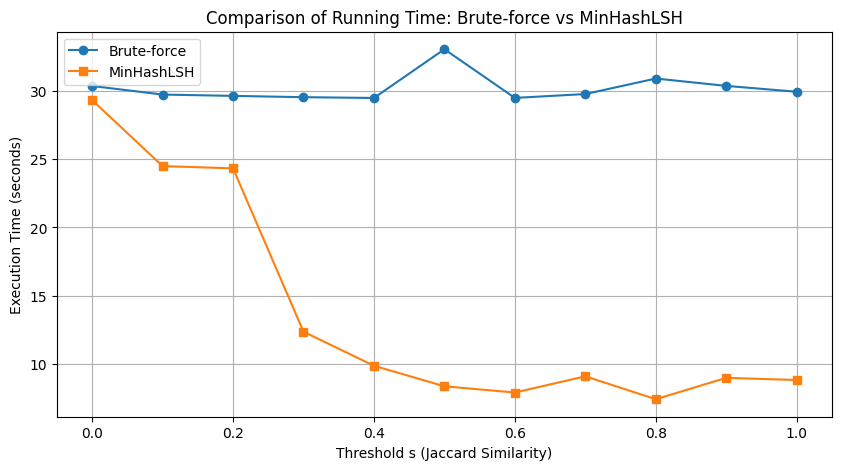

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(s_values, brute_force_times, label="Brute-force", marker='o')
plt.plot(s_values, minhash_times, label="MinHashLSH", marker='s')

plt.xlabel("Threshold s (Jaccard Similarity)")
plt.ylabel("Execution Time (seconds)")
plt.title("Comparison of Running Time: Brute-force vs MinHashLSH")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
spark.stop()